# Monte Carlo Control

In [10]:
import numpy as np
import easy21env as easy21
import easy21_table
import pandas as pd
import easy21_table
from numba import njit
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
%matplotlib inline  
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)

N0 = 1000

Populating the interactive namespace from numpy and matplotlib


In [11]:
q = easy21_table.create_q()
q_N = easy21_table.create_q()
q_sum_reward = easy21_table.create_q()

In [12]:
@njit
def episode(q, q_N, q_sum_reward):
    for i in range(1000000):
        player_card = easy21.take(0)
        dealer_card = easy21.take(0)
        player_score = player_card[0]
        rewards = [] 
        player_scores = [player_score]
        terminal = False
        actions = []
        dealer_score = dealer_card[0]
        while terminal == False:
            
            # Choose action based on epsilon greedy policy
            hit_N = easy21_table.get_q(q_N, dealer_score, player_score, 1)
            stick_N = easy21_table.get_q(q_N, dealer_score, player_score, 0)
            total_S_N = hit_N + stick_N
            epsilon = N0 / (N0 + total_S_N)
            #epsilon = 1.0
            if random.random() < epsilon: 
                action = 1 if random.random() > 0.5  else 0 
            else:
                action_0 = easy21_table.get_q(q, dealer_score, player_score, 0)
                action_1 = easy21_table.get_q(q, dealer_score, player_score, 1)
                if action_0 > action_1:
                    action = 0
                else:
                    action = 1
                
            # Play round 
            dealer_card, player_score, terminal, reward = easy21.step(dealer_card, player_score, action)
            terminal = terminal 
            
            rewards.append(reward)
            actions.append(action)
            #Update player scores in non-terminal state.
            if terminal == False:
                player_scores.append(player_score)
                
        expected_future_reward = 0
        for i in range(len(player_scores) - 1, 0, -1):
            expected_future_reward += rewards[i] 
            q_N = easy21_table.set_q(q_N, dealer_score, player_scores[i], actions[i],
                               easy21_table.get_q(q_N, dealer_score, player_scores[i], actions[i]) + 1)
            q_sum_reward = easy21_table.set_q(q_sum_reward, dealer_score, player_scores[i], actions[i], 
                               easy21_table.get_q(q_sum_reward, dealer_score, player_scores[i], actions[i]) + reward)
            q = easy21_table.set_q(q, dealer_score, player_scores[i], actions[i],
                                   easy21_table.get_q(q_sum_reward, dealer_score, player_scores[i], actions[i]) / 
                                   easy21_table.get_q(q_N, dealer_score, player_scores[i], actions[i]))
    return q, q_N, q_sum_reward

In [13]:
q, q_N, q_sum_reward = episode(q, q_N, q_sum_reward)

In [14]:
z = np.zeros((30, 11))
x, y = np.meshgrid(range(1,22), range(1,11))

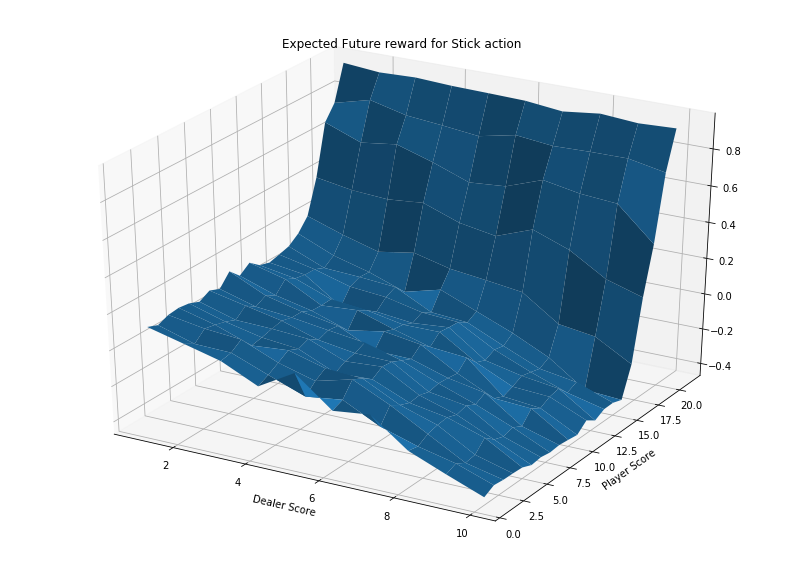

In [15]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(y, x , q[:,:,0])
plt.xlabel('Dealer Score')
plt.ylabel('Player Score')
plt.title('Expected Future reward for Stick action')

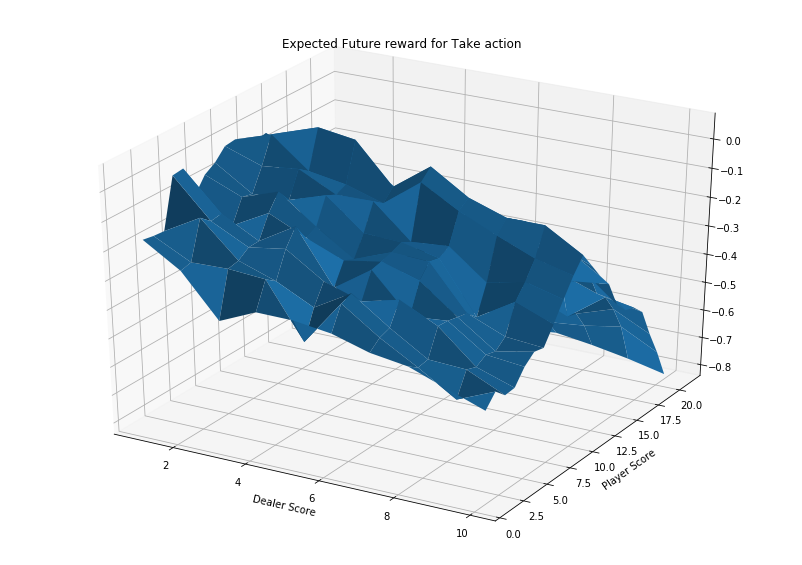

In [16]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(y, x , q[:,:,1])
plt.xlabel('Dealer Score')
plt.ylabel('Player Score')
plt.title('Expected Future reward for Take action')

In [17]:
max_q = np.max(q, axis=2)

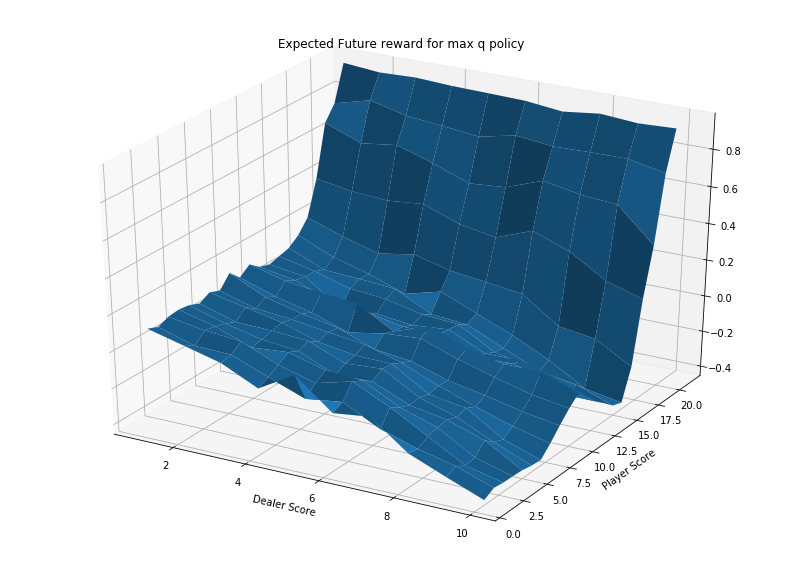

In [18]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(y, x , max_q)
plt.xlabel('Dealer Score')
plt.ylabel('Player Score')
plt.title('Expected Future reward for max q policy')

In [19]:
pickle.dump(max_q, open("q_optimal.p", "wb" ))